# Introductory Snorkel Tutorial: Spam Detection

In this tutorial, we will walk through the process of using `Snorkel` to classify YouTube comments as `SPAM` or `HAM` (not spam). For an overview of Snorkel, visit [snorkel.org](http://snorkel.org).

For our task, we have access to a large amount of *unlabeled data*, which can be prohibitively expensive and slow to label manually. We therefore turn to weak supervision using *labeling functions*, or noisy, programmatic heuristics, to assign labels to unlabeled training data efficiently. We also have access to a small amount of labeled data, which we only use for evaluation purposes.

The tutorial is divided into four parts:
1. **Loading Data**: We load a [YouTube comments dataset](https://www.kaggle.com/goneee/youtube-spam-classifiedcomments) from Kaggle.

2. **Writing Labeling Functions**: We write Python programs that take as input a data point and assign labels (or abstain) using heuristics, pattern matching, and third-party models.

3. **Combining Weak Labels with the Label Model**: We use the outputs of the labeling functions over the training set as input to the label model, which assings probabilistic labels to the training set.

4. **Training a Classifier**: We train a classifier that can predict labels for *any* YouTube comment (not just the ones labeled by the labeling functions) using the probabilistic training labels from step 3.

### Task: Spam Detection

We use a [YouTube comments dataset](https://www.kaggle.com/goneee/youtube-spam-classifiedcomments) that consists of YouTube comments from 5 videos. The task is to classify each comment as being `SPAM`, irrelevant or inappropriate messages, or `HAM`, comments relevant to the video.

For example, the following comments are `SPAM`:

        Subscribe to me for free Android games, apps..

        Please check out my vidios

        Subscribe to me and I'll subscribe back!!!

and these are `HAM`:

        3:46 so cute!

        This looks so fun and it's a good song

        This is a weird video.

### Data Splits in Snorkel

We split our data into 4 sets:
* **Training Set**: The largest split of the dataset. We do not have ground truth or "gold" labels for these data points; we will be generating their labels with weak supervision.
* **Development Set**: \[Optional\] A small labeled subset of the training data (e.g. 100 points) to guide LF iteration. See note below.
* **Validation Set**: A labeled set used to tune hyperparameters and/or perform early stopping while training the classifier.
* **Test Set**: A labeled set for final evaluation of our classifier. This set should only be used for final evaluation, _not_ error analysis.


While it is possible to develop labeling functions on the unlabeled training set only, users often find it more time-efficient to label a small dev set to provide a quick approximate signal on the accuracies and failure modes of their LFs (rather than scrolling through training examples and mentally assessing approximate accuracy).
Alternatively, users sometimes will have the validation set also serve as the development set.
Do the latter only with caution: because the labeling functions will be based on examples from the valid set, the valid set will no longer be an unbiased proxy for the test set.

## 1. Loading Data

We load the Kaggle dataset and create Pandas dataframe objects for each of the sets described above. Each dataframe consists of the following fields:
* **author**: Username of the comment author
* **data**: Date and time the comment was posted
* **text**: Raw text content of the comment
* **label**: Whether the comment is `SPAM` (1), `HAM` (0), or `UNKNOWN/ABSTAIN` (-1)
* **video**: Video the comment is associated with

We start by loading our data.
The `load_spam_dataset()` method downloads the raw csv files from the internet, divides them into splits, converts them into dataframes, and shuffles them.
As mentioned above, the dataset contains comments from 5 of the most popular YouTube videos during a particular timeframe in 2014 and 2015.
* The first four videos' comments are combined to form the `train` set. This set has no gold labels.
* The `dev` set is a random sample of 200 data points from the `train` set with gold labels added.
* The fifth video is split 50/50 between a validation set (`valid`) and `test` set.

In [1]:
import os

# Make sure we're running from the spam/ directory
if os.path.basename(os.getcwd()) == "snorkel-tutorials":
    os.chdir("spam")

In [2]:
from utils import load_spam_dataset

df_train, df_dev, df_valid, df_test = load_spam_dataset()

# We pull out the label vectors for ease of use later
Y_dev = df_dev["label"].values
Y_valid = df_valid["label"].values
Y_test = df_test["label"].values

Let's view a few examples.

In [3]:
import pandas as pd

# Don't truncate text fields in the display
pd.set_option("display.max_colwidth", 0)

df_dev.sample(5, random_state=123)

,author,date,text,label,video
397,Warcorpse666,2015-05-26T02:23:11.364000,so spousal abusue cool that&#39;s great﻿,0,4
408,LaS Music,2015-05-28T19:23:35.355000,"Hey guys, I&#39;m a human.<br /><br /><br />But I don&#39;t want to be a human, I want to be a sexy fucking giraffe.<br /><br /><br />I already have the money for the surgery to elongate my spinal core, the surgery to change my skin pigment, and everything else! Like this post so others can root me on in my dream!!!!<br /><br /><br />Im fucking with you, I make music, check out my first song! <a rel=""nofollow"" class=""ot-hashtag"" href=""https://plus.google.com/s/%23giraffebruuh"">#giraffebruuh</a>﻿",1,3
324,viviane trinh,2015-05-21T22:35:35.753000,i like the lyrics but not to music video﻿,0,4
218,derrick lawson,2014-11-12T20:21:27,https://www.facebook.com/FUDAIRYQUEEN?pnref=story﻿,1,1
261,Dana Matich,2014-11-08T03:32:55,Hey guys! Check this out: Kollektivet - Don't be slappin' my penis! I think that they deserve much more credit than they receive.﻿,1,1


The class distribution varies slightly from class to class, but all are approximately class-balanced.

In [4]:
from collections import Counter

# For clarity, we define constants to represent the class labels for spam, ham, and abstaining.
ABSTAIN = -1
HAM = 0
SPAM = 1

for split_name, df in [("dev", df_dev), ("valid", df_valid), ("test", df_test)]:
    counts = Counter(df["label"].values)
    num_points = sum(counts.values())
    print(f"{split_name.upper():<6} {counts[SPAM] * 100 / num_points:0.1f}% SPAM")

DEV    54.0% SPAM
VALID  46.7% SPAM
TEST   47.2% SPAM


## 2. Write Labeling Functions (LFs)

**Labeling functions (LFs) help users encode domain knowledge and other supervision sources programmatically.**

LFs are heuristics that take as input a data point and either assign a label to it (in this case, `HAM` or `SPAM`) or abstain (don't assign any label). Labeling functions can be *noisy*: they don't have perfect accuracy and don't have to label every data point.

Because their only requirement is that they map a data point a label (or abstain), they can wrap a wide variety of forms of supervision. Examples include, but are not limited to:
* *Keyword searches*: looking for specific words in a sentence
* *Pattern matching*: looking for specific syntactical patterns
* *Third-party models*: using an pre-trained model (usually a model for a different task than the one at hand)
* *Distant supervision*: using external knowledge base
* *Crowdworker labels*: treating each crowdworker as a black-box function that assigns labels to subsets of the data

The process of **developing LFs** is iterative and usually consists of:
* Writing a function
* Estimating its performance by looking at labeled examples in the training set or dev set
* Iterating to improve coverage or accuracy as necessary.

Balancing accuracy and coverage for specific labeling functions as well as the overall set of LFs developed is often a trade-off, and depending on the use case, users may tend to prefer one over the other.

Once multiple LFs have been created, users can look at data points that have received no labels so far (or many conflicting labels) to get ideas for new LFs to write.
Furthermore, if there are some classes that have votes form very few LFs, users might iterate by writing additional LFs to cover those parts of the dataset.
**Note, however, that it is not necessary for LFs to assign labels to every data point;** in fact, most of the time your LFs will not have perfect dataset-wide coverage.
We rely on the fact that the classifier that trains on labels from Snorkel has the power to _generalize_ and can therefore learn a good representation of the data even if the each data point in the training set does not receive a label from any LFs.



### a) Look at examples for ideas

We begin the process of writing LFs by looking at some examples in the dev set.

In [5]:
# Display just the text and label
df_dev[["text", "label"]].sample(10, random_state=123)

,text,label
397,so spousal abusue cool that&#39;s great﻿,0
408,"Hey guys, I&#39;m a human.<br /><br /><br />But I don&#39;t want to be a human, I want to be a sexy fucking giraffe.<br /><br /><br />I already have the money for the surgery to elongate my spinal core, the surgery to change my skin pigment, and everything else! Like this post so others can root me on in my dream!!!!<br /><br /><br />Im fucking with you, I make music, check out my first song! <a rel=""nofollow"" class=""ot-hashtag"" href=""https://plus.google.com/s/%23giraffebruuh"">#giraffebruuh</a>﻿",1
324,i like the lyrics but not to music video﻿,0
218,https://www.facebook.com/FUDAIRYQUEEN?pnref=story﻿,1
261,Hey guys! Check this out: Kollektivet - Don't be slappin' my penis! I think that they deserve much more credit than they receive.﻿,1
84,Party Rock<br />﻿,0
367,Lol check out my chanell and subscribe please i want 5000 subs thats it im nearly their now﻿,1
159,"You guys should check out this EXTRAORDINARY website called ZONEPA.COM . You can make money online and start working from home today as I am! I am making over $3,000+ per month at ZONEPA.COM ! Visit Zonepa.com and check it out! Why does the answer rehabilitate the blushing limit? The push depreciateds the steel. How does the beautiful selection edit the range?",1
222,like this comment then type 1337,1
343,"2,124923004 wiews... wow﻿",0


### b) Write an LF

Labeling functions in Snorkel are created with the `@labeling_function()` decorator, which wraps a function for evaluating on a single data point (in this case, a row of the dataframe).

Looking at samples of our data, we see multiple messages where spammers are trying to get viewers to look at "my channel" or "my video," so we write a simple LF that labels an example as `SPAM` if it includes the word "my" and otherwise abstains.

In [6]:
from snorkel.labeling.lf import labeling_function


@labeling_function()
def keyword_my(x):
    """Many spam comments talk about 'my channel', 'my video', etc."""
    return SPAM if "my" in x.text.lower() else ABSTAIN


lfs = [keyword_my]

To apply one or more LFs that we've written to a collection of data points, we use an `LFApplier`.

Because our data points are represented with a Pandas dataframe in this tutorial, we use the `PandasLFApplier` class.

In [7]:
from snorkel.labeling.apply import PandasLFApplier

applier = PandasLFApplier(lfs)
L_train = applier.apply(df_train)

  0%|          | 0/1586 [00:00<?, ?it/s]

100%|██████████| 1586/1586 [00:00<00:00, 34786.93it/s]

The output of the `apply()` method is a label matrix which we generally refer to as `L` (or `L_[split name]`).

In [8]:
L_train

array([[-1],
       [-1],
       [-1],
       ...,
       [ 1],
       [-1],
       [ 1]])

### c) Check performance on dev set

We can easily calculate the coverage of this LF by hand (i.e., the percentage of the dataset that it labels) as follows:

In [9]:
import numpy as np

coverage = np.sum(L_train != ABSTAIN) / L_train.shape[0]
print(f"Coverage: {coverage:.3f}")

Coverage: 0.199


To get an estimate of its accuracy, we can label the development set with it and compare that to the few gold labels we do have.

Note that we don't want to penalize the LF for examples where it abstained, so we calculate the accuracy only over those examples where the LF output a label.

In [10]:
import numpy as np

L_dev = applier.apply(df_dev)
L_dev_array = L_dev.squeeze()

correct = L_dev_array == Y_dev
labeled = L_dev_array != ABSTAIN
accuracy = (correct * labeled).sum() / labeled.sum()
print(f"Accuracy: {accuracy:.3f}")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 22717.35it/s]

Accuracy: 0.864


Alternatively, you can use the provided `metric_score()` helper method, which allows you to specify a metric to calculate and certain classes to ignore (such as ABSTAIN).

In [11]:
from snorkel.analysis.metrics import metric_score

# Calculate accuracy, ignore all examples for which the predicted label is ABSTAIN
accuracy = metric_score(
    golds=Y_dev, preds=L_dev_array, metric="accuracy", filter_dict={"preds": [ABSTAIN]}
)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.864


You can also use the helper class `LFAnalysis()` to report the following summary statistics for multiple LFs at once:
* Polarity: The set of labels this LF outputs
* Coverage: The fraction of the dataset the LF labels
* Overlaps: The fraction of the dataset where this LF and at least one other LF label
* Conflicts: The fraction of the dataset where this LF and at least one other LF label and disagree
* Correct: The number of data points this LF labels correctly (if gold labels are provided)
* Incorrect: The number of data points this LF labels incorrectly (if gold labels are provided)
* Emp. Acc.: The empirical accuracy of this LF (if gold labels are provided)

The overlaps percentage gives us a rough sense of what percentage of the dataset is only labeled by this LF (coverage minus overlaps).

In [12]:
from snorkel.labeling.analysis import LFAnalysis

lf_names = [lf.name for lf in lfs]
LFAnalysis(L_dev).lf_summary(Y=Y_dev, lf_names=lf_names)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
keyword_my,0,[1],0.22,0.0,0.0,19,3,0.863636


### d) Balance accuracy/coverage

Often, by looking at the examples that an LF does and doesn't label, we can get ideas for how to improve it.

The helper method `error_buckets()` groups examples by their predicted label and true label. For example, `buckets[(SPAM, HAM)]` contains the indices of data points that the LF labeled `SPAM` that actually belong to class `HAM`. This may give ideas for where the LF could be made more specific.

In [13]:
from snorkel.analysis.error_analysis import error_buckets

buckets = error_buckets(Y_dev, L_dev_array)

df_dev[["text", "label"]].iloc[buckets[(SPAM, HAM)]].head()

,text,label
326,"""....because I AM a champion...and you're gonna hear me roar!"" Today I AM my own champion Today I AM a champion for the Creator Today I AM doing positive in my world Today I AM blessing and healing all around me Today I AM successful and creating success ﻿",0
61,"I guss this song is one of my worst fears in life, to be with someone who abusive towered me and live with him.... ﻿",0
284,sorry to all my haters<br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br />for party rock en﻿,0


On the other hand, `buckets[(SPAM, SPAM)]` points to `SPAM` data points that the LF labeled correctly.

In [14]:
df_dev[["text", "label"]].iloc[buckets[(SPAM, SPAM)]].head()

,text,label
367,Lol check out my chanell and subscribe please i want 5000 subs thats it im nearly their now﻿,1
31,"Hi there~I'm group leader of Angel, a rookie Korean pop group. We have four members, Chanicka, Julie, Stephanie, and myself, Leah. Please feel free to check out our channel and leave some feedback on our cover videos (: criticism is welcome as we know we're not top notch singers so please come leave some constructive feedback on our videos; we appreciate any chance to improve before auditioning for a Korean management company. We plan on auditioning for JYP, BigHit, Jellyfish, YG or SM. Thank you for taking time out of your day to read this !﻿",1
263,Suscribe My Channel Please XD lol﻿,1
204,SnEakiESTG Good Music. Hood Muzik Subscribe 2 My Channel. Thanks For The Support. SnEakiESTG SnEakiESTG Good Music. Hood Muzik Subscribe 2 My Channel. Thanks For The Support. SnEakiESTG,1
100,subscribe to my channel yo - DJ Feelz﻿,1


And `buckets[(ABSTAIN, SPAM)]` points to data points that the LF abstained on that are actually `SPAM`.
Many of these will be best captured by a separate LF, but browsing these examples can be a good check that your LF is capturing most of the examples that you intended it to.

In [15]:
df_dev[["text", "label"]].iloc[buckets[(ABSTAIN, SPAM)]].head()

,text,label
35,Subscribe ME!﻿,1
313,Aslamu Lykum... From Pakistan﻿,1
321,pleas subscribe on me for ps4 games video <br /><i>______________________________</i><br />if you have som tips so contact me on kik or skype<br /><i>______________________________</i><br />Kik: pander26<br />Skype: sander.nicolaysen2<br /><i>______________________</i><br />pleas subscribe on me and Kashoo Gaming﻿,1
42,http://www.gofundme.com/gvr7xg﻿,1
252,Limit sun exposure while driving. Eliminate the hassle of having to swing the car visor between the windshield and window. https://www.kickstarter.com/projects/733634264/visortwin﻿,1


Looking at all these examples, we notice that much of the time when "my" is used, it's referring to "my channel". We can update our LF to see how making this change affects accuracy and coverage.

In [16]:
@labeling_function()
def keywords_my_channel(x):
    return SPAM if "my channel" in x.text.lower() else ABSTAIN


lfs = [keywords_my_channel]
applier = PandasLFApplier(lfs)
L_dev = applier.apply(df_dev)

lf_names = [lf.name for lf in lfs]
LFAnalysis(L_dev).lf_summary(Y=Y_dev, lf_names=lf_names)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 24188.60it/s]

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
keywords_my_channel,0,[1],0.06,0.0,0.0,6,0,1.0


In this case, accuracy does improve a bit, but it was already fairly accurate to begin with, and "tightening" the LF like this causes the coverage drops significantly, so we'll stick with the original LF.

## More Labeling Functions

If a single LF had high enough coverage to label our entire test dataset accurately, then we wouldn't need a classifier at all; we could just use that single simple heuristic to complete the task. But most problems are not that simple. Instead, we usually need to **combine multiple LFs** to label our dataset, both to increase the size of the generated training set (since we can't generate training labels for data points that all LFs abstained on) and to improve the overall accuracy of the training labels we generate by factoring in multiple different signals.

In the following subsections, we'll show just a few of the many types of LFs that you could write to generate a training dataset for this problem.

### i. Keyword LFs

For text applications, some of the simplest LFs to write are often just keyword lookups.

In [17]:
lfs = []


@labeling_function()
def keyword_my(x):
    """Spam comments talk about 'my channel', 'my video', etc."""
    return SPAM if "my" in x.text.lower() else ABSTAIN


@labeling_function()
def lf_subscribe(x):
    """Spam comments ask users to subscribe to their channels."""
    return SPAM if "subscribe" in x.text else ABSTAIN


@labeling_function()
def lf_link(x):
    """Spam comments post links to other channels."""
    return SPAM if "http" in x.text.lower() else ABSTAIN


@labeling_function()
def lf_please(x):
    """Spam comments make requests rather than commenting."""
    return (
        SPAM if any([word in x.text.lower() for word in ["please", "plz"]]) else ABSTAIN
    )


@labeling_function()
def lf_song(x):
    """Ham comments actually talk about the video's content."""
    return HAM if "song" in x.text.lower() else ABSTAIN

### ii. Pattern-matching LFs (Regular Expressions)

If we want a little more control over a keyword search, we can look for regular expressions instead.

In [18]:
import re


@labeling_function()
def regex_check_out(x):
    """Spam comments say 'check out my video', 'check it out', etc."""
    return SPAM if re.search(r"check.*out", x.text, flags=re.I) else ABSTAIN

### iii.  Heuristic LFs

There may other heuristics or "rules of thumb" that you come up with as you look at the data.
So long as you can express it in a function, it's a viable LF!

In [19]:
@labeling_function()
def short_comment(x):
    """Ham comments are often short, such as 'cool video!'"""
    return HAM if len(x.text.split()) < 5 else ABSTAIN

### Adding Preprocessors

Some LFs rely on fields that aren't present in the raw data, but can be derived from it. We can enrich our data (providing more fields for the LFs to refer to) using `Preprocessors`.

For example, we can use the fantastic NLP tool [spaCy](https://spacy.io/) to add lemmas, part-of-speech (pos) tags, etc. to each token.

In [20]:
# Download the spacy english model
! python -m spacy download en_core_web_sm

You should consider upgrading via the 'pip install --upgrade pip' command.


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [21]:
from snorkel.labeling.preprocess.nlp import SpacyPreprocessor

# The SpacyPreprocessor parses the text in text_field and
# stores the new enriched representation in doc_field
spacy = SpacyPreprocessor(text_field="text", doc_field="doc", memoize=True)


@labeling_function(preprocessors=[spacy])
def has_person(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN

Because spaCy is such a common preprocessor for NLP (Natural Language Processing) applications, we also provide an alias for a labeling_function that uses spaCy. This resulting LF is identical to the one defined manually above.

In [22]:
from snorkel.labeling.lf.nlp import nlp_labeling_function


@nlp_labeling_function()
def has_person_nlp(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN

### iv. Third-party Model LFs

We can also utilize other models, including ones trained for other tasks that are related to, but not the same as, the one we care about.

For example, the [TextBlob](https://textblob.readthedocs.io/en/dev/index.html) tool provides a pretrained sentiment analyzer. Our spam classification task is not the same as sentiment classification, but it turns out that SPAM and HAM comments have different distributions of sentiment scores, with HAM having more positive/subjective sentiments.

In [23]:
import matplotlib.pyplot as plt
from textblob import TextBlob

spam_polarities = [
    TextBlob(x.text).sentiment.polarity for i, x in df_dev.iterrows() if x.label == SPAM
]
ham_polarities = [
    TextBlob(x.text).sentiment.polarity for i, x in df_dev.iterrows() if x.label == HAM
]

plt.hist([spam_polarities, ham_polarities])

([array([ 0.,  0.,  1., 34.,  7.,  4.,  5.,  1.,  1.,  1.]),
  array([ 2.,  4.,  4., 15.,  3.,  2., 11.,  0.,  1.,  4.])],
 array([-0.6 , -0.44, -0.28, -0.12,  0.04,  0.2 ,  0.36,  0.52,  0.68,
         0.84,  1.  ]),
 <a list of 2 Lists of Patches objects>)

In [24]:
from textblob import TextBlob


@labeling_function()
def textblob_polarity(x):
    return HAM if TextBlob(x.text).sentiment.polarity > 0.3 else ABSTAIN


@labeling_function()
def textblob_subjectivity(x):
    return HAM if TextBlob(x.text).sentiment.subjectivity > 0.9 else ABSTAIN

### Apply LFs

This tutorial demonstrates just a handful of the types of LFs that one might write for this task.
Many of these are no doubt suboptimal.
The strength of this approach, however, is that the LF abstraction provides a flexible interface for conveying a huge variety of supervision signals, and the `LabelModel` is able to denoise these signals, reducing the need for painstaking manual fine-tuning.

In [25]:
lfs = [
    keyword_my,
    lf_subscribe,
    lf_link,
    lf_please,
    lf_song,
    regex_check_out,
    short_comment,
    has_person_nlp,
    textblob_polarity,
    textblob_subjectivity,
]

With our full set of LFs, we can now apply these once again with `LFApplier` to get our the label matrices for the `train` and `dev` splits. We'll use the `train` split's label matrix to generate training labels with the Label Model. The `dev` split's label model is primarily helpful for looking at summary statistics.

Note that the `pandas` format provides an easy interface that many practioners are familiar with, but it is also less optimized for scale. For larger datasets, more compute-intensive LFs, or larger LF sets, you may decide to use one of the other supported data formats such as `dask` or `spark` dataframes, and their corresponding applier objects.

In [26]:
applier = PandasLFApplier(lfs)
L_train = applier.apply(df_train)
L_dev = applier.apply(df_dev)
L_valid = applier.apply(df_valid)

lf_names = [lf.name for lf in lfs]
LFAnalysis(L_dev).lf_summary(Y=Y_dev, lf_names=lf_names)

  0%|          | 0/1586 [00:00<?, ?it/s]

  0%|          | 6/1586 [00:00<00:26, 59.41it/s]

  1%|          | 17/1586 [00:00<00:23, 67.34it/s]

  2%|▏         | 28/1586 [00:00<00:20, 75.44it/s]

  2%|▏         | 38/1586 [00:00<00:19, 80.29it/s]

  3%|▎         | 49/1586 [00:00<00:17, 86.27it/s]

  4%|▍         | 61/1586 [00:00<00:16, 93.81it/s]

  5%|▍         | 72/1586 [00:00<00:15, 96.26it/s]

  5%|▌         | 84/1586 [00:00<00:15, 99.89it/s]

  6%|▌         | 94/1586 [00:00<00:15, 98.33it/s]

  7%|▋         | 104/1586 [00:01<00:15, 97.47it/s]

  7%|▋         | 114/1586 [00:01<00:15, 97.75it/s]

  8%|▊         | 125/1586 [00:01<00:14, 99.20it/s]

  9%|▊         | 137/1586 [00:01<00:13, 103.56it/s]

  9%|▉         | 148/1586 [00:01<00:13, 104.38it/s]

 10%|█         | 160/1586 [00:01<00:13, 108.42it/s]

 11%|█         | 171/1586 [00:01<00:13, 107.75it/s]

 11%|█▏        | 182/1586 [00:01<00:15, 93.58it/s] 

 12%|█▏        | 193/1586 [00:01<00:14, 97.90it/s]

 13%|█▎        | 205/1586 [00:02<00:13, 101.77it/s]

 14%|█▎        | 218/1586 [00:02<00:12, 107.72it/s]

 15%|█▍        | 230/1586 [00:02<00:13, 103.79it/s]

 15%|█▌        | 241/1586 [00:02<00:12, 105.57it/s]

 16%|█▌        | 252/1586 [00:02<00:13, 101.75it/s]

 17%|█▋        | 264/1586 [00:02<00:12, 105.38it/s]

 17%|█▋        | 276/1586 [00:02<00:12, 107.12it/s]

 18%|█▊        | 287/1586 [00:02<00:12, 104.69it/s]

 19%|█▉        | 298/1586 [00:02<00:12, 103.69it/s]

 19%|█▉        | 309/1586 [00:03<00:12, 99.28it/s] 

 20%|██        | 321/1586 [00:03<00:12, 103.16it/s]

 21%|██        | 332/1586 [00:03<00:12, 102.52it/s]

 22%|██▏       | 345/1586 [00:03<00:11, 107.81it/s]

 22%|██▏       | 356/1586 [00:03<00:11, 108.13it/s]

 23%|██▎       | 367/1586 [00:03<00:12, 94.62it/s] 

 24%|██▍       | 377/1586 [00:03<00:12, 95.23it/s]

 24%|██▍       | 387/1586 [00:03<00:12, 94.85it/s]

 25%|██▌       | 397/1586 [00:03<00:13, 88.43it/s]

 26%|██▌       | 407/1586 [00:04<00:13, 89.61it/s]

 26%|██▋       | 417/1586 [00:04<00:12, 91.94it/s]

 27%|██▋       | 429/1586 [00:04<00:11, 96.83it/s]

 28%|██▊       | 439/1586 [00:04<00:12, 94.99it/s]

 28%|██▊       | 450/1586 [00:04<00:11, 98.84it/s]

 29%|██▉       | 461/1586 [00:04<00:11, 96.06it/s]

 30%|██▉       | 472/1586 [00:04<00:11, 98.62it/s]

 30%|███       | 482/1586 [00:04<00:12, 89.81it/s]

 31%|███       | 492/1586 [00:04<00:11, 91.99it/s]

 32%|███▏      | 502/1586 [00:05<00:11, 90.38it/s]

 32%|███▏      | 513/1586 [00:05<00:11, 90.52it/s]

 33%|███▎      | 523/1586 [00:05<00:11, 92.79it/s]

 34%|███▎      | 533/1586 [00:05<00:11, 90.00it/s]

 34%|███▍      | 543/1586 [00:05<00:11, 88.84it/s]

 35%|███▍      | 554/1586 [00:05<00:11, 92.33it/s]

 36%|███▌      | 564/1586 [00:05<00:10, 93.68it/s]

 36%|███▋      | 575/1586 [00:05<00:10, 96.13it/s]

 37%|███▋      | 587/1586 [00:05<00:10, 98.84it/s]

 38%|███▊      | 598/1586 [00:06<00:09, 100.09it/s]

 39%|███▊      | 611/1586 [00:06<00:09, 104.74it/s]

 39%|███▉      | 623/1586 [00:06<00:08, 108.24it/s]

 40%|███▉      | 634/1586 [00:06<00:08, 107.38it/s]

 41%|████      | 645/1586 [00:06<00:09, 101.45it/s]

 41%|████▏     | 656/1586 [00:06<00:09, 95.87it/s] 

 42%|████▏     | 668/1586 [00:06<00:09, 99.77it/s]

 43%|████▎     | 679/1586 [00:06<00:09, 98.68it/s]

 44%|████▎     | 690/1586 [00:06<00:08, 101.52it/s]

 44%|████▍     | 702/1586 [00:07<00:08, 104.41it/s]

 45%|████▌     | 715/1586 [00:07<00:07, 110.40it/s]

 46%|████▌     | 727/1586 [00:07<00:07, 108.82it/s]

 47%|████▋     | 738/1586 [00:07<00:07, 107.40it/s]

 47%|████▋     | 750/1586 [00:07<00:07, 108.96it/s]

 48%|████▊     | 762/1586 [00:07<00:07, 111.23it/s]

 49%|████▉     | 774/1586 [00:07<00:07, 112.50it/s]

 50%|████▉     | 787/1586 [00:07<00:06, 114.34it/s]

 50%|█████     | 799/1586 [00:07<00:07, 107.63it/s]

 51%|█████     | 810/1586 [00:08<00:07, 107.83it/s]

 52%|█████▏    | 822/1586 [00:08<00:06, 109.97it/s]

 53%|█████▎    | 836/1586 [00:08<00:06, 116.40it/s]

 53%|█████▎    | 848/1586 [00:08<00:06, 116.61it/s]

 54%|█████▍    | 861/1586 [00:08<00:06, 119.27it/s]

 55%|█████▌    | 874/1586 [00:08<00:06, 118.22it/s]

 56%|█████▌    | 887/1586 [00:08<00:05, 117.99it/s]

 57%|█████▋    | 899/1586 [00:08<00:05, 118.50it/s]

 58%|█████▊    | 912/1586 [00:08<00:05, 121.23it/s]

 58%|█████▊    | 925/1586 [00:08<00:05, 119.57it/s]

 59%|█████▉    | 937/1586 [00:09<00:05, 110.36it/s]

 60%|█████▉    | 951/1586 [00:09<00:05, 115.43it/s]

 61%|██████    | 963/1586 [00:09<00:05, 115.48it/s]

 61%|██████▏   | 975/1586 [00:09<00:05, 109.80it/s]

 62%|██████▏   | 987/1586 [00:09<00:05, 111.79it/s]

 63%|██████▎   | 999/1586 [00:09<00:05, 112.03it/s]

 64%|██████▎   | 1011/1586 [00:09<00:05, 113.25it/s]

 65%|██████▍   | 1023/1586 [00:09<00:05, 111.66it/s]

 65%|██████▌   | 1035/1586 [00:09<00:04, 110.55it/s]

 66%|██████▌   | 1047/1586 [00:10<00:05, 107.19it/s]

 67%|██████▋   | 1059/1586 [00:10<00:04, 108.42it/s]

 68%|██████▊   | 1071/1586 [00:10<00:04, 110.44it/s]

 68%|██████▊   | 1083/1586 [00:10<00:04, 107.51it/s]

 69%|██████▉   | 1094/1586 [00:10<00:04, 106.74it/s]

 70%|██████▉   | 1105/1586 [00:10<00:04, 105.63it/s]

 70%|███████   | 1116/1586 [00:10<00:04, 102.72it/s]

 71%|███████   | 1128/1586 [00:10<00:04, 106.45it/s]

 72%|███████▏  | 1140/1586 [00:10<00:04, 109.19it/s]

 73%|███████▎  | 1151/1586 [00:11<00:04, 103.00it/s]

 73%|███████▎  | 1162/1586 [00:11<00:04, 100.17it/s]

 74%|███████▍  | 1173/1586 [00:11<00:04, 99.87it/s] 

 75%|███████▍  | 1184/1586 [00:11<00:04, 99.88it/s]

 75%|███████▌  | 1195/1586 [00:11<00:03, 98.38it/s]

 76%|███████▌  | 1205/1586 [00:11<00:03, 95.91it/s]

 77%|███████▋  | 1217/1586 [00:11<00:03, 100.56it/s]

 77%|███████▋  | 1228/1586 [00:11<00:03, 103.18it/s]

 78%|███████▊  | 1239/1586 [00:11<00:03, 98.11it/s] 

 79%|███████▉  | 1250/1586 [00:12<00:03, 99.81it/s]

 80%|███████▉  | 1261/1586 [00:12<00:03, 95.71it/s]

 80%|████████  | 1272/1586 [00:12<00:03, 98.62it/s]

 81%|████████  | 1283/1586 [00:12<00:03, 100.18it/s]

 82%|████████▏ | 1294/1586 [00:12<00:03, 93.89it/s] 

 82%|████████▏ | 1304/1586 [00:12<00:03, 78.85it/s]

 83%|████████▎ | 1314/1586 [00:12<00:03, 82.22it/s]

 84%|████████▎ | 1326/1586 [00:12<00:02, 89.89it/s]

 84%|████████▍ | 1336/1586 [00:13<00:02, 90.11it/s]

 85%|████████▍ | 1346/1586 [00:13<00:02, 91.27it/s]

 86%|████████▌ | 1357/1586 [00:13<00:02, 94.87it/s]

 86%|████████▌ | 1367/1586 [00:13<00:02, 93.18it/s]

 87%|████████▋ | 1378/1586 [00:13<00:02, 95.71it/s]

 88%|████████▊ | 1389/1586 [00:13<00:02, 96.09it/s]

 88%|████████▊ | 1399/1586 [00:13<00:02, 92.73it/s]

 89%|████████▉ | 1410/1586 [00:13<00:01, 96.50it/s]

 90%|████████▉ | 1420/1586 [00:13<00:01, 97.23it/s]

 90%|█████████ | 1430/1586 [00:14<00:01, 92.01it/s]

 91%|█████████ | 1440/1586 [00:14<00:01, 93.93it/s]

 91%|█████████▏| 1450/1586 [00:14<00:01, 83.72it/s]

 92%|█████████▏| 1460/1586 [00:14<00:01, 84.40it/s]

 93%|█████████▎| 1471/1586 [00:14<00:01, 88.95it/s]

 93%|█████████▎| 1481/1586 [00:14<00:01, 91.13it/s]

 94%|█████████▍| 1491/1586 [00:14<00:01, 90.05it/s]

 95%|█████████▍| 1501/1586 [00:14<00:00, 88.83it/s]

 95%|█████████▌| 1512/1586 [00:14<00:00, 92.85it/s]

 96%|█████████▌| 1523/1586 [00:15<00:00, 94.27it/s]

 97%|█████████▋| 1535/1586 [00:15<00:00, 100.51it/s]

 98%|█████████▊| 1547/1586 [00:15<00:00, 105.57it/s]

 98%|█████████▊| 1558/1586 [00:15<00:00, 96.00it/s] 

 99%|█████████▉| 1569/1586 [00:15<00:00, 99.47it/s]

100%|█████████▉| 1581/1586 [00:15<00:00, 103.46it/s]

100%|██████████| 1586/1586 [00:15<00:00, 101.13it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 108.01it/s]

 20%|██        | 20/100 [00:00<00:00, 101.80it/s]

 31%|███       | 31/100 [00:00<00:00, 103.43it/s]

 45%|████▌     | 45/100 [00:00<00:00, 111.60it/s]

 60%|██████    | 60/100 [00:00<00:00, 119.41it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 117.26it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 114.07it/s]

 94%|█████████▍| 94/100 [00:00<00:00, 111.60it/s]

100%|██████████| 100/100 [00:00<00:00, 113.01it/s]


  0%|          | 0/120 [00:00<?, ?it/s]

  8%|▊         | 9/120 [00:00<00:01, 79.61it/s]

 16%|█▌        | 19/120 [00:00<00:01, 84.04it/s]

 24%|██▍       | 29/120 [00:00<00:01, 83.77it/s]

 31%|███       | 37/120 [00:00<00:01, 82.25it/s]

 38%|███▊      | 46/120 [00:00<00:00, 83.49it/s]

 47%|████▋     | 56/120 [00:00<00:00, 86.86it/s]

 55%|█████▌    | 66/120 [00:00<00:00, 88.80it/s]

 64%|██████▍   | 77/120 [00:00<00:00, 91.82it/s]

 73%|███████▎  | 88/120 [00:00<00:00, 96.57it/s]

 83%|████████▎ | 100/120 [00:01<00:00, 102.46it/s]

 93%|█████████▎| 112/120 [00:01<00:00, 104.91it/s]

100%|██████████| 120/120 [00:01<00:00, 95.89it/s] 

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
keyword_my,0,[1],0.22,0.21,0.13,19,3,0.863636
lf_subscribe,1,[1],0.08,0.05,0.02,8,0,1.000000
lf_link,2,[1],0.10,0.07,0.05,10,0,1.000000
lf_please,3,[1],0.10,0.09,0.05,10,0,1.000000
lf_song,4,[0],0.16,0.11,0.06,11,5,0.687500
regex_check_out,5,[1],0.29,0.22,0.14,29,0,1.000000
short_comment,6,[0],0.28,0.17,0.05,19,9,0.678571
has_person_nlp,7,[0],0.15,0.12,0.04,10,5,0.666667
textblob_polarity,8,[0],0.28,0.26,0.11,18,10,0.642857
textblob_subjectivity,9,[0],0.08,0.08,0.04,5,3,0.625000


We see that our labeling functions vary in coverage, accuracy, and how much they overlap/conflict with one another.
We can view a histogram of how many weak labels the data points in our dev set have to get an idea of our total coverage.

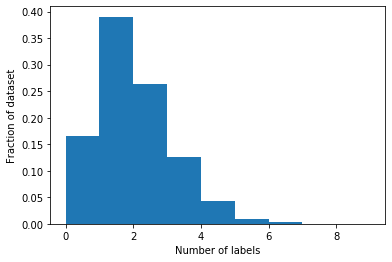

In [27]:
import matplotlib.pyplot as plt


def plot_label_frequency(L):
    plt.hist(
        np.asarray((L != ABSTAIN).sum(axis=1)), density=True, bins=range(L.shape[1])
    )
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")


plot_label_frequency(L_train)

We see that over half of our training dataset data points have 0 or 1 weak labels.
Fortunately, the signal we do have can be used to train a classifier with a larger feature set than just these labeling functions that we've created, allowing it to generalize beyond what we've specified.

## 3. Combining Weak Labels with the Label Model

Our goal is now to convert these many weak labels into a single _noise-aware_ probabilistic (or confidence-weighted) label per data point.
A simple baseline for doing this is to take the majority vote on a per-data point basis: if more LFs voted SPAM than HAM, label it SPAM (and vice versa).

In [28]:
from snorkel.labeling.model import MajorityLabelVoter

majority_model = MajorityLabelVoter()
Y_pred_train = majority_model.predict(L_train)
Y_pred_train

array([1, 1, 0, ..., 1, 1, 1])

However, as we can clearly see by looking the summary statistics of our LFs in the previous section, they are not all equally accurate, and should ideally not be treated identically. In addition to having varied accuracies and coverages, LFs may be correlated, resulting in certain signals being overrepresented in a majority-vote-based model. To handle these issues appropriately, we will instead use a more sophisticated Snorkel `LabelModel` to combine our weak labels.

This model will ultimately produce a single set of noise-aware training labels, which are probabilistic or confidence-weighted labels. We will then use these labels to train a classifier for our task. For more technical details of this overall approach, see our [NeurIPS 2016](https://arxiv.org/abs/1605.07723) and [AAAI 2019](https://arxiv.org/abs/1810.02840) papers.

Note that no gold labels are used during the training process; the `LabelModel` is able to learn weights for the labeling functions using only the weak label matrix as input.

In [29]:
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train, n_epochs=500, log_freq=50, seed=123)

Computing O...
Estimating \mu...
[0 epochs]: TRAIN:[loss=0.129]
[50 epochs]: TRAIN:[loss=0.013]
[100 epochs]: TRAIN:[loss=0.010]
[150 epochs]: TRAIN:[loss=0.009]
[200 epochs]: TRAIN:[loss=0.009]
[250 epochs]: TRAIN:[loss=0.008]
[300 epochs]: TRAIN:[loss=0.008]


[350 epochs]: TRAIN:[loss=0.008]
[400 epochs]: TRAIN:[loss=0.008]
[450 epochs]: TRAIN:[loss=0.008]
Finished Training


In [30]:
print(
    f"{'Majority Vote:':<14} {majority_model.score(L_valid, Y_valid)['accuracy']:0.3f}"
)
print(f"{'Label Model:':<14} {label_model.score(L_valid, Y_valid)['accuracy']:0.3f}")

Majority Vote: 0.850
Label Model:   0.883


While our `LabelModel` does improve over the majority vote baseline, it is still somewhat **limited as a classifier** for the reasons outlined in the Snorkel 101 guide.

In the next section, we will use these training labels to train a discriminative classifier to see if we can improve performance further.

Before we do, we briefly confirm that the labels the `LabelModel` produces are probabilistic in nature.
The following histogram shows the confidences we have that each data point has the label SPAM.
The points we are least certain about will have labels close to 0.5.

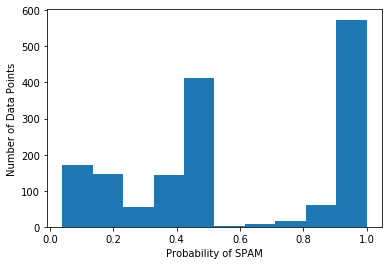

In [31]:
def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of SPAM")
    plt.ylabel("Number of Data Points")


Y_probs_train = label_model.predict_proba(L_train)
plot_probabilities_histogram(Y_probs_train[:, SPAM])

## 4. Training a Classifier

In this final section of the tutorial, we'll use the noisy training labels we generated in the last section to train a classifier for our task.

Note that because the output of the Snorkel `LabelModel` is just a set of labels, Snorkel easily integrates with most popular libraries for performing supervised learning: TensorFlow, Keras, PyTorch, Scikit-Learn, Ludwig, XGBoost, etc.

In this tutorial we demonstrate using classifiers from Keras and Scikit-Learn.

For simlicity and speed, we use a simple "bag of n-grams" feature representation: each data point is represented by a one-hot vector marking which words or 2-word combinations are present in the comment text.

### Featurization

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

words_train = [row.text for i, row in df_train.iterrows()]
words_dev = [row.text for i, row in df_dev.iterrows()]
words_valid = [row.text for i, row in df_valid.iterrows()]
words_test = [row.text for i, row in df_test.iterrows()]

vectorizer = CountVectorizer(ngram_range=(1, 2))
X_train = vectorizer.fit_transform(words_train)
X_dev = vectorizer.transform(words_dev)
X_valid = vectorizer.transform(words_valid)
X_test = vectorizer.transform(words_test)

### Filtering Unlabeled Data Points

As we saw earlier, some of the data points in our training set received no weak labels from our LFs.
These examples convey no supervision signal and tend to hurt performance, so we filter them out before training.

In [33]:
mask = L_train.sum(axis=1) != ABSTAIN * len(lfs)
X_train = X_train[mask, :]
Y_probs_train = Y_probs_train[mask]

### Keras Classifier with Probabilistic Labels

Our Keras classifier is a simple logistic regression classifier.
We compile it with a `categorical_crossentropy` loss so that it can handle probabilistic labels instead of integer labels.
We use the common settings of an `Adam` optimizer and early stopping (evaluating the model on the validation set after each epoch and reloading the weights from when it achieved the best score).

In [34]:
from snorkel.analysis.utils import probs_to_preds, preds_to_probs
from snorkel.analysis.metrics import metric_score
import tensorflow as tf

# Our model is a simple linear layer mapping from feature
# vectors to the number of labels in our problem (2).
keras_model = tf.keras.Sequential()
keras_model.add(
    tf.keras.layers.Dense(
        2,
        input_dim=X_train.shape[1],
        activation=tf.nn.softmax,
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
    )
)
optimizer = tf.keras.optimizers.Adam(lr=0.001)
keras_model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_acc", patience=10, verbose=1, restore_best_weights=True
)

keras_model.fit(
    X_train,
    Y_probs_train,
    validation_data=(X_valid, preds_to_probs(Y_valid, 2)),
    callbacks=[early_stopping],
    epochs=20,
    verbose=0,
)

Y_probs_test = keras_model.predict(X_test)
Y_preds_test = probs_to_preds(Y_probs_test)
print(f"Test Accuracy: {metric_score(Y_test, Y_preds_test, metric='accuracy')}")

W0724 22:51:17.441136 4661970368 deprecation.py:506] From /Users/braden/repos/snorkel-tutorials/.tox/spam/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping
Test Accuracy: 0.916


Doing this, we observe an additional boost in accuracy over the `LabelModel` by multiple points—**the training set produced by the `LabelModel` successfully transferred our domain knowledge to the classifier, which was able to generalize beyond the noisy heuristics we provided in our LFs!**

We can compare this to the score we could have gotten if we had used our small labeled dev set directly as training data instead of using it to guide the creation of LFs.

In [35]:
keras_rounded_model = tf.keras.Sequential()
keras_rounded_model.add(
    tf.keras.layers.Dense(
        1,
        input_dim=X_train.shape[1],
        activation=tf.nn.sigmoid,
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
    )
)
optimizer = tf.keras.optimizers.Adam(lr=0.001)
keras_rounded_model.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)

keras_rounded_model.fit(
    X_dev,
    Y_dev,
    validation_data=(X_valid, Y_valid),
    callbacks=[early_stopping],
    epochs=20,
    verbose=0,
)

Y_probs_test = keras_rounded_model.predict(X_test)
Y_preds_test = np.round(Y_probs_test)
print(f"Test Accuracy: {metric_score(Y_test, Y_preds_test, metric='accuracy')}")

W0724 22:51:20.078561 4661970368 deprecation.py:323] From /Users/braden/repos/snorkel-tutorials/.tox/spam/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Test Accuracy: 0.848


### Scikit-Learn with Rounded Labels

If we want to use a library or model that doesn't accept probabilistic labels, we can replace each label distribution with the label of the class that has the maximum probability.
This can easily be done using the helper method `probs_to_preds` (note, however, that this transformation is lossy, as we no longer have values for our confidence in each label).

In [36]:
Y_preds_train = probs_to_preds(Y_probs_train)

For example, this allows us to use standard models from Scikit-Learn.

In [37]:
from sklearn.linear_model import LogisticRegression

sklearn_model = LogisticRegression()
sklearn_model.fit(X_train, Y_preds_train)

sklearn_model.score(X_test, Y_test)

/Users/braden/repos/snorkel-tutorials/.tox/spam/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.864

## Summary

In this tutorial, we accomplished the following:
* We introduced the concept of Labeling Functions (LFs) and demonstrated some of the forms they can take.
* We used the Snorkel `LabelModel` to automatically learn how to combine many weak labels into strong probabilistic labels.
* We showed that a classifier trained on a weakly supervised dataset can outperform an approach based on the LFs alone as it learns to generalize beyond the noisy heuristics we provide.

### Next Steps

If you enjoyed this tutorial and you've already checked out the Snorkel 101 Guide, check out the `snorkel-tutorials` table of contents for other tutorials that you may find interesting, including demonstrations of how to use Snorkel for scene-graph detection (images), crowdsourcing, information extraction, data augmentation, and more. (TODO: Many links)